In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import linalg
from scipy.io import loadmat
from matplotlib.patches import Rectangle

import tensor_utils as utils

# Load data

$\mathbf{\mathsf{X}}$ is a $145 \times 145 \times 200$ array corresponding to $x \times y \times f$.

We build a tensor $\mathbf{\mathsf{T}}$ by extracting patches of the image. The corresponding shape is $\text{patch} \times \text{position} \times f$.

Since $145 = 5 \times 29$, we can either extract $5 \times 5 = 25$ patches of size $29 \times 29 = 841$ or $841$ patches of size $25$.

In [2]:
X_gt = loadmat('data/Indian_pines_gt.mat')['indian_pines_gt'] # Ground truth

X = loadmat('data/Indian_pines_corrected.mat')['indian_pines_corrected'] # x * y * freq
nf = X.shape[2]

# a, b = 5, 29
a, b = 29, 5

T = np.array([X[a*i:a*(i+1), a*j:a*(j+1), :].reshape(a*a, nf) for i in range(b) for j in range(b)], dtype=float) # patch * pos * freq

Plot one slice

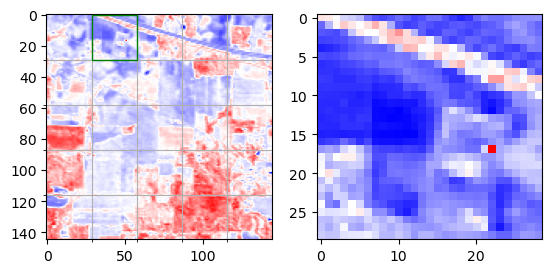

In [3]:
freq = 41
patch = 1

fig, ax = plt.subplots(1, 2)
ax[0].imshow(X[:, :, freq], cmap='bwr')
minor_ticks = np.arange(0, 145, 29)
ax[0].set_xticks(minor_ticks, minor=True)
ax[0].set_yticks(minor_ticks, minor=True)
ax[0].grid(which='minor')
rect = Rectangle(((a*patch)%(a*b), ((a*patch)//(a*b))*a), a, a, linewidth=1, edgecolor='green', facecolor='none', zorder=3)
ax[0].add_patch(rect)
ax[1].imshow(T[patch, :, freq].reshape(a, a), cmap='bwr');

# Random tensor analysis

In [4]:
n = T.shape
N = np.sum(n)
d = len(n)
c = n/N
eps = 1

B = utils.make_B(n, eps)
T0 = T*B
T0 = (T0-T0.mean())/T0.std(ddof=1)

setting = "$N = {{{}}} \\quad \\mathbf{{c}} = {{{}}}^\\top \\quad \\varepsilon = {}$".format(N, list(np.round(c, 2)), eps)

In [5]:
sigma, svecs = utils.CPD1(T0)

In [6]:
PhiM = utils.Phi(T0, svecs)
eigvals, eigvecs = linalg.eigh(PhiM)

In [7]:
xmin, xmax = utils.plot_interv(eigvals.min(), eigvals.max())

xx = np.linspace(xmin, xmax, 500)
eta = 1e-6
gg = utils.stieltjes(xx+eta*1j, c, eps, maxiter=np.inf)
LSD = gg['g'].imag/np.pi

beta_est, align_th = utils.alignments(sigma, c, eps)
print("beta_est =", beta_est)

beta_est = 1973.087351957851


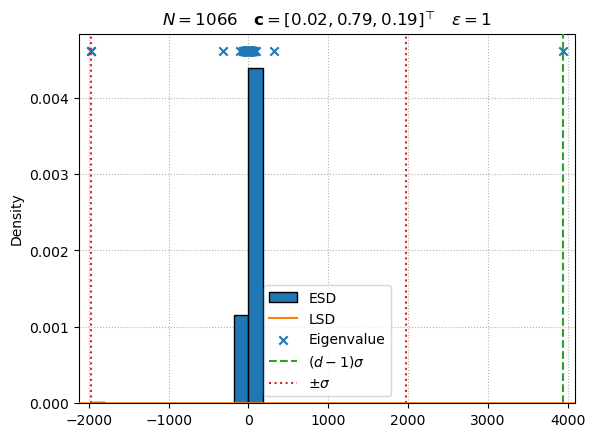

In [8]:
plt.hist(eigvals, density=True, bins='sqrt', color='C0', edgecolor='black', zorder=2, label="ESD")
plt.plot(xx, LSD, zorder=4, color='C1', label="LSD")
ymin, ymax = plt.ylim()
plt.scatter(eigvals, ymax*np.ones_like(eigvals), marker='x', color='C0', zorder=3, label="Eigenvalue")
plt.axvline((d-1)*sigma, ls='--', color='C2', zorder=3, label="$( d - 1 ) \\sigma$")
plt.axvline(sigma, ls=':', color='C3', zorder=3, label="$\\pm \\sigma$")
plt.axvline(-sigma, ls=':', color='C3', zorder=3)
plt.grid(ls=':')
plt.xlim(xmin, xmax)
plt.ylabel("Density")
plt.legend()
plt.title(setting);

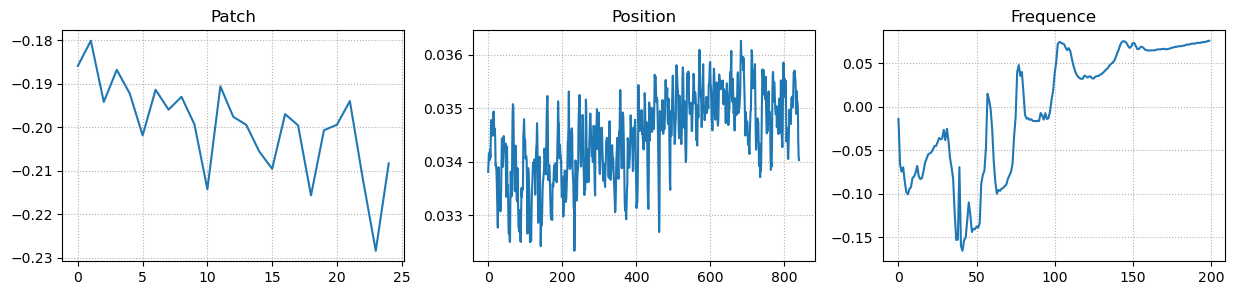

In [9]:
fig, ax = plt.subplots(1, d, figsize=(15, 3))
for i in range(d):
    ax[i].plot(svecs[i])
    ax[i].grid(ls=':')
    ax[i].set_title(["Patch", "Position", "Frequence"][i])

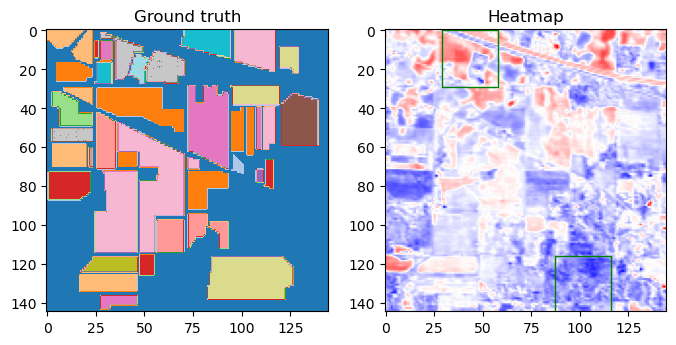

In [10]:
fig, ax = plt.subplots(1, 2, figsize=(8, 4))
ax[0].imshow(X_gt, cmap='tab20')
ax[0].set_title("Ground truth")
ax[1].imshow(np.sum(X*svecs[2]/np.sum(svecs[2]), axis=2), cmap='bwr')
ax[1].set_title("Heatmap")
for patch in [np.argmin(svecs[0]), np.argmax(svecs[0])]:
    rect = Rectangle(((a*patch)%(a*b), ((a*patch)//(a*b))*a), a, a, linewidth=1, edgecolor='green', facecolor='none')
    ax[1].add_patch(rect)